# MSDS 7331 - Mini-Project: SVM&LR Classification
## Team: Dineen Parker, Dale Legband, Ryan Shuhart
collaboration site: https://github.com/rlshuhart/MSDS7331_Mini-Lab

### Log to capture iterations of findings and ideas for feature selection and analysis

1. First attempt of logistic model revealed need to one-hot encode categorical variables
2. After numerically encoding categorical variables, the logistic model more or less predicted all to not default.
3. Changeing penalty on logistic model from l2 to l1 improved the model by about 3 percentage points.
4. Changing class_weight='balanced' negatively impacted model
5. Changing C to 100 had no impact
6. Changing C to .0001 had small negative impact
7. Reviewed logistic coefficients on scaled data and it appears the most recent pay status (PAY_0_Sept), the most recent two bill amounts ('BILL_AMT1_Sept', 'BILL_AMT2_Aug'), the most recent two payment amounts are the highest predictors ('PAY_AMT1_Sept', 'PAY_AMT2_Aug').
8. Full SVM Model was stopped after not completing after 2 hours. SGD will be pursued instead.

## SVM and Logistic Regression Modeling  
* [50 points] Create a logistic regression model and a support vector machine model for the classiﬁcation task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is ﬁne to use. 
* [10 points] Discuss the advantages of each model for each classiﬁcation task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efﬁciency? Explain in detail.  
* [30 points] Use the weights from logistic regression to interpret the importance of different features for each classiﬁcation task. Explain your interpretation in detail. Why do you think some variables are more important? 
* [10 points] Look at the chosen support vectors for the classiﬁcation task. Do these provide any insight into the data? Explain

In [2]:
### Modules Used ###

# Data manipulation: pandas and numpy
import pandas as pd
import numpy as np

# Visualization: seaborn and matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import time

# Read in preprocessed data from previous assignment

In [4]:
# Random but useful fact: if the first record in a csv file is 
# "ID" than Excel will interpret it as a SYLK file
# https://annalear.ca/2010/06/10/why-excel-thinks-your-csv-is-a-sylk/

#data_url = "https://raw.githubusercontent.com/rlshuhart/MSDS7331_Project_1/master/cc_data/cc_data_processed.csv"
data_url = "../MSDS7331_Project_1/cc_data/cc_data_processed.csv"

cc_data = pd.read_csv(data_url, index_col='ID')

In [5]:
print(cc_data.info())
print()
print(cc_data.columns)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 27 columns):
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null object
EDUCATION                     30000 non-null object
MARRIAGE                      30000 non-null object
AGE                           30000 non-null int64
PAY_0_Sept                    30000 non-null int64
PAY_2_Aug                     30000 non-null int64
PAY_3_July                    30000 non-null int64
PAY_4_June                    30000 non-null int64
PAY_5_May                     30000 non-null int64
PAY_6_April                   30000 non-null int64
BILL_AMT1_Sept                30000 non-null int64
BILL_AMT2_Aug                 30000 non-null int64
BILL_AMT3_July                30000 non-null int64
BILL_AMT4_June                30000 non-null int64
BILL_AMT5_May                 30000 non-null int64
BILL_AMT6_April               30000 non-null int64
PAY_AMT1_Sept        

# Additional Preprocessing of data

### One hot encoding of categorical variables

In [6]:
# makeing copy of data to retain original input for now. 
# Have to add .copy() or any change will reflect in the original too.
cc_data_processed = cc_data.copy()

cats = ['SEX', 'EDUCATION', 'MARRIAGE','AGE_range', 'LIMIT_BAL_range']

# SEX convert to isMale
cc_data_processed['isMale'] = cc_data['SEX']=='Male'

# Two options for Education: 
# If treating ordinal then keep single columnn but label in numerical order
# if nominal then create dummy variables.
# Trying ordinal first with 'Others' as the highest. Previous exploration
# showed this group have better rates of default which continued the trend
# of more education means less likely to default:
cc_data_processed['EDUCATION'] = cc_data['EDUCATION'].apply({'High School':0,
                                                             'University':1,
                                                             'Graduate School':2, 
                                                             'Others':3}.get)

# Marriage is nominal category therefore converting to dummies

cc_data_processed = pd.concat((cc_data_processed, 
                               pd.get_dummies(cc_data['MARRIAGE'], prefix='Marriage')), 
                               axis=1)

# Age range is ordinal category:
cc_data_processed['AGE_range'] = cc_data['AGE_range'].apply({'21-30':0,
                                                             '31-40':1,
                                                             '41-50':2, 
                                                             '51-60':3,
                                                             '61-70':4,
                                                             '71-80+':5}.get)
# Limit_Bal_Range is ordingal
cc_data_processed['LIMIT_BAL_range'] = cc_data['LIMIT_BAL_range'].apply({'0-250k':0,
                                                                         '>250k-500k':1,
                                                                         '>500k-750k':2,
                                                                         '>750k':3}.get)

# Drop unused features:
# 'Default_Yes_No' - Used for visualization labeling only and same as 'default payment next month'
# 'AGE' - Using Age_range instead, may bring back
cc_data_processed.drop(['Default_Yes_No','AGE', 'SEX','MARRIAGE', 'LIMIT_BAL'], axis=1, inplace=True)

print(cc_data_processed.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 26 columns):
EDUCATION                     30000 non-null int64
PAY_0_Sept                    30000 non-null int64
PAY_2_Aug                     30000 non-null int64
PAY_3_July                    30000 non-null int64
PAY_4_June                    30000 non-null int64
PAY_5_May                     30000 non-null int64
PAY_6_April                   30000 non-null int64
BILL_AMT1_Sept                30000 non-null int64
BILL_AMT2_Aug                 30000 non-null int64
BILL_AMT3_July                30000 non-null int64
BILL_AMT4_June                30000 non-null int64
BILL_AMT5_May                 30000 non-null int64
BILL_AMT6_April               30000 non-null int64
PAY_AMT1_Sept                 30000 non-null int64
PAY_AMT2_Aug                  30000 non-null int64
PAY_AMT3_July                 30000 non-null int64
PAY_AMT4_June                 30000 non-null int64
PAY_AMT5_May            

### Convert data to numpy arrays

In [7]:
cc_data_target = cc_data_processed['default payment next month'].values
cc_data_Xs = cc_data_processed.drop('default payment next month', axis='columns').values
cc_data_Xs_names = cc_data_processed.drop('default payment next month', axis='columns').columns

# Prediction Models

In [21]:
# Scikit Modules
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics as mt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn import grid_search

In [12]:
# Create Cross Validation object
num_cv_iterations = 3
num_instances = len(cc_data_target)
cv_object = ShuffleSplit(n=num_instances,
                         n_iter=num_cv_iterations,
                         test_size  = 0.2)

In [9]:
# Sample Default Rate
sample_d_rt = (1 - cc_data_target.sum() / len(cc_data_target))*100
print("The sample default rate is: %.1f%%"  % sample_d_rt)

# The sample default rate is the same as predicting all zeros (or no defaults)
all_zeros = np.zeros(len(cc_data_target))
all_zero_score = mt.accuracy_score(cc_data_target,all_zeros)*100
print("The models should have an accuracy better than predicting all non-defaults of %.1f%%"  % all_zero_score)

The sample default rate is: 77.9%
The models should have an accuracy better than predicting all non-defaults of 77.9%


## Logistic Regression

#### Review of different parameters

In [10]:
def classify(model, X, y):
    accuracies = cross_val_score(model,X,y=y)
    predicted = cross_val_predict(model,X,y=y)
    print(accuracies)
    return(predicted)

In [47]:
def grid_searcher(model, params, cv_object):
    clf = grid_search.GridSearchCV(model, params, cv=cv_object,n_jobs=-1)
    clf.fit(cc_data_Xs,cc_data_target)
    #print(clf.grid_scores_ )
    print("The best estimator: ",clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)

c_values = [.1,1,10,100,1000]#np.arange(.01, .1, 0.01)
model = LogisticRegression()
params = {'penalty':('l1','l2'), 'C':c_values, 'class_weight':(None, 'balanced')}

grid_searcher(model, params, cv_object)

The best estimator:  LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.8135
{'C': 10, 'class_weight': None, 'penalty': 'l1'}


In [9]:
# Using 
model = LogisticRegression(penalty='l1', C=1.0, class_weight=None)
p = classify(model, cc_data_Xs, cc_data_target)

#below compares how close to all zero prediction
print("Model predicts %.1f%% will not default" % (mt.accuracy_score(p,all_zeros)*100))

[ 0.806   0.8136  0.8079]
Model predicts 92.6% will not default


#### Find coefficients 

In [13]:
def full_classify(y, X, cv_object, model, scale=False):
    start = time.time()
    for iter_num, (train_indices, test_indices) in enumerate(cv_object):
        if scale == True:
            scl_obj = StandardScaler()
            scl_obj.fit(X[train_indices])
            X_train_scaled = scl_obj.transform(X[train_indices])
            X_test_scaled = scl_obj.transform(X[test_indices])
            model.fit(X_train_scaled,y[train_indices])
            y_hat = model.predict(X_test_scaled)
            print("SCALED DATA")
        elif scale == False:
            model.fit(X[train_indices],y[train_indices])  # train object
            y_hat = model.predict(X[test_indices]) # get test set precitions

        # print the accuracy and confusion matrix 
        print("\n====Iteration",iter_num," ====")
        print("accuracy", mt.accuracy_score(y[test_indices],y_hat) )
        print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))
        print("Classification Report:\n",mt.classification_report(y[test_indices],y_hat))
        print("ROC Score \n",mt.roc_auc_score(y[test_indices],y_hat))
    print('done. It took', time.time()-start, 'seconds.')    
    return model.coef_

# captures coeficients of last training set
coef = full_classify(cc_data_target, cc_data_Xs, cv_object, LogisticRegression(penalty='l1', C=1.0, class_weight=None))
coef_scaled = full_classify(cc_data_target, cc_data_Xs, cv_object, LogisticRegression(penalty='l1', C=1.0, class_weight=None), scale = True)


====Iteration 0  ====
accuracy 0.807166666667
confusion matrix
 [[4516  165]
 [ 992  327]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.96      0.89      4681
          1       0.66      0.25      0.36      1319

avg / total       0.79      0.81      0.77      6000

ROC Score 
 0.606333104371

====Iteration 1  ====
accuracy 0.805833333333
confusion matrix
 [[4519  149]
 [1016  316]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4668
          1       0.68      0.24      0.35      1332

avg / total       0.79      0.81      0.77      6000

ROC Score 
 0.602658892826

====Iteration 2  ====
accuracy 0.817666666667
confusion matrix
 [[4573  146]
 [ 948  333]]
Classification Report:
              precision    recall  f1-score   support

          0       0.83      0.97      0.89      4719
          1       0.70      0.26      0.38      1281

avg / t

C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 0  ====
accuracy 0.807333333333
confusion matrix
 [[4527  134]
 [1022  317]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4661
          1       0.70      0.24      0.35      1339

avg / total       0.79      0.81      0.77      6000

ROC Score 
 0.603997321617


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 1  ====
accuracy 0.812833333333
confusion matrix
 [[4562  125]
 [ 998  315]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4687
          1       0.72      0.24      0.36      1313

avg / total       0.80      0.81      0.77      6000

ROC Score 
 0.606619547415


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 2  ====
accuracy 0.810833333333
confusion matrix
 [[4557  126]
 [1009  308]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4683
          1       0.71      0.23      0.35      1317

avg / total       0.79      0.81      0.77      6000

ROC Score 
 0.603479507373
done. It took 2.4589998722076416 seconds.


In [11]:
print("Coefficients and column names same length: " + str(len(coef_scaled.T)==len(cc_data_Xs_names)))
print()
# sort these attributes and spit them out
zip_vars = zip(coef_scaled.T,cc_data_Xs_names) # combine attributes
# zip_vars.sort(key = lambda t: np.abs(t[0])) # sort them by the magnitude of the weight
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

Coefficients and column names same length: True

EDUCATION has weight of 0.0156850571431
PAY_0_Sept has weight of 0.651147977715
PAY_2_Aug has weight of 0.0962016243575
PAY_3_July has weight of 0.0843306040032
PAY_4_June has weight of 0.0366203750712
PAY_5_May has weight of 0.0276187321736
PAY_6_April has weight of 0.0212430439869
BILL_AMT1_Sept has weight of -0.339038994114
BILL_AMT2_Aug has weight of 0.0954910238993
BILL_AMT3_July has weight of 0.0689404951298
BILL_AMT4_June has weight of -0.017279524743
BILL_AMT5_May has weight of 0.0873815297051
BILL_AMT6_April has weight of 0.00023797392475
PAY_AMT1_Sept has weight of -0.225312838407
PAY_AMT2_Aug has weight of -0.32158020386
PAY_AMT3_July has weight of -0.0582844180864
PAY_AMT4_June has weight of -0.0788333383582
PAY_AMT5_May has weight of -0.0301768342505
PAY_AMT6_April has weight of -0.0425636435724
AGE_range has weight of 0.0488084788228
LIMIT_BAL_range has weight of -0.0360111633814
isMale has weight of 0.0675021386253
Marriag

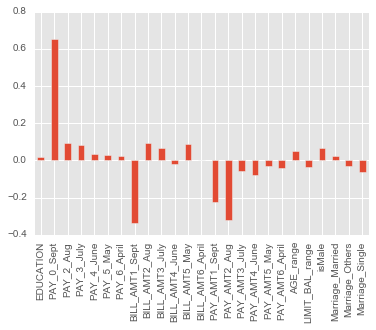

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(coef_scaled[0],index=cc_data_Xs_names)
weights.plot(kind='bar')
plt.show()

# Intrepretting weights of Logistic Model

# Support Vector Machine

In [ ]:
# Create New Cross Validation object
cv_object = ShuffleSplit(n=len(cc_data_target), n_iter=10, test_size  = 0.2)

a_values = [.1,1,10,100,1000]#np.arange(.01, .1, 0.01)
model = SGDClassifier(n_iter=1)
params = {'penalty':('l1','l2'), 'alpha':a_values, 'fit_intercept':(True, False)}

grid_searcher(model, params, cv_object)

# regularize_const = 1
# iterations = 5
# model = SGDClassifier(alpha=regularize_const,
#         fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
#         loss='hinge', n_iter=iterations, n_jobs=-1, penalty='l1')

In [52]:
model = SVC(C=0.05, kernel='linear', degree=3, gamma='auto')
full_classify(cc_data_target, cc_data_Xs, cv_object, model, scale=True)

C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 0  ====
accuracy 0.807666666667
confusion matrix
 [[4535  119]
 [1035  311]]
Classification Report:
              precision    recall  f1-score   support

          0       0.81      0.97      0.89      4654
          1       0.72      0.23      0.35      1346

avg / total       0.79      0.81      0.77      6000

ROC Score 
 0.602742787524


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 1  ====
accuracy 0.806333333333
confusion matrix
 [[4516  134]
 [1028  322]]
Classification Report:
              precision    recall  f1-score   support

          0       0.81      0.97      0.89      4650
          1       0.71      0.24      0.36      1350

avg / total       0.79      0.81      0.77      6000

ROC Score 
 0.604850657109


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 2  ====
accuracy 0.810166666667
confusion matrix
 [[4547  111]
 [1028  314]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.98      0.89      4658
          1       0.74      0.23      0.36      1342

avg / total       0.80      0.81      0.77      6000

ROC Score 
 0.605074582837


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 3  ====
accuracy 0.809
confusion matrix
 [[4550  143]
 [1003  304]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4693
          1       0.68      0.23      0.35      1307

avg / total       0.79      0.81      0.77      6000

ROC Score 
 0.601061405981


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 4  ====
accuracy 0.807
confusion matrix
 [[4542  151]
 [1007  300]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4693
          1       0.67      0.23      0.34      1307

avg / total       0.79      0.81      0.77      6000

ROC Score 
 0.598678850837


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 5  ====
accuracy 0.810333333333
confusion matrix
 [[4552  151]
 [ 987  310]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4703
          1       0.67      0.24      0.35      1297

avg / total       0.79      0.81      0.77      6000

ROC Score 
 0.603452970766


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 6  ====
accuracy 0.802
confusion matrix
 [[4507  118]
 [1070  305]]
Classification Report:
              precision    recall  f1-score   support

          0       0.81      0.97      0.88      4625
          1       0.72      0.22      0.34      1375

avg / total       0.79      0.80      0.76      6000

ROC Score 
 0.598152334152


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 7  ====
accuracy 0.813
confusion matrix
 [[4579  146]
 [ 976  299]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4725
          1       0.67      0.23      0.35      1275

avg / total       0.79      0.81      0.78      6000

ROC Score 
 0.601805166511


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 8  ====
accuracy 0.8095
confusion matrix
 [[4551  136]
 [1007  306]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4687
          1       0.69      0.23      0.35      1313

avg / total       0.79      0.81      0.77      6000

ROC Score 
 0.60201882311


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 9  ====
accuracy 0.815
confusion matrix
 [[4555  125]
 [ 985  335]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4680
          1       0.73      0.25      0.38      1320

avg / total       0.80      0.81      0.78      6000

ROC Score 
 0.613539238539
done. It took 232.18228006362915 seconds.


array([[  8.61119959e-06,   4.49068282e-01,   2.39127226e-01,
          3.56403411e-05,   1.96526608e-05,   6.53516485e-05,
          4.33942587e-06,  -2.94514658e-05,   3.77247554e-05,
         -3.36210844e-05,   3.66307618e-05,  -4.10352395e-05,
          3.40787547e-05,  -1.27971512e-04,  -9.06973346e-06,
          5.79745695e-06,  -1.15075641e-05,  -3.22636433e-05,
         -4.26330131e-06,  -1.04141247e-05,  -6.97930408e-06,
         -4.23013515e-06,   1.35373828e-05,  -2.27278958e-05,
         -8.33081837e-06]])